In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from glob import glob
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from keras_unet_collection import models, base, utils

2023-04-22 01:42:55.528932: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
from gp2 import Runner

2023-04-22 01:42:57.256782: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 01:42:57.477671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 01:42:57.480251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 01:42:57.480271: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 01:42:57.484146: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 

In [4]:
R = Runner(verbose=True, classifier='kunet2d')

2023-04-22 01:42:57.551031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 01:42:57.882499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 01:42:57.884948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 01:42:57.894630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2  KUNet2D ***
Working directory: /tmp/tmpbrxp_xb0GP2
Verbose mode active!
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 512, 512, 16) 144         input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 512, 512, 16) 64          unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (ReLU)  (None, 512, 512, 16) 0           unet_down0_0_bn[0][0]            
________

In [5]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [6]:
images = images[:5000]
masks = masks[:5000]

In [7]:
images.shape

(5000, 512, 512, 1)

In [8]:
masks.shape

(5000, 512, 512, 1)

In [9]:
print(images.max())

255


In [10]:
print(images.min())

0


In [11]:
print(masks.max())

True


In [12]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}
PERCENT_TO_REPLACE = 30

In [13]:
R.setup_data(images, masks, dataset_size=5000, weights=weights)

Weights OK!


In [14]:
RUNS = 10

In [15]:
for run in range(RUNS):
    print('***')
    print('RUN:', run)
    t0 = time.time()
    R.run_classifier(patience_counter=4)
    R.run_discriminator()
    l = R.find_machine_labels()
    if l == 0:
        print('No more machine labels.')
        print('TOOK', time.time()-t0, 'seconds')
        break
    R.relabel(percent_to_replace=PERCENT_TO_REPLACE)
    print('TOOK', time.time()-t0, 'seconds')
    

***
RUN: 0


2023-04-22 01:44:01.185361: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-22 01:44:01.202993: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245755000 Hz


Epoch 1/100


2023-04-22 01:44:06.166587: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-22 01:44:06.821791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-22 01:44:07.443775: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-22 01:44:07.443798: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-22 01:44:07.443861: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-22 01:44:07.459553: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-22 01:44:08.261507: I tensorflow/stream_exec

4/4 [==============================] - 41s 6s/step - loss: 0.8555 - dice_coef: 0.1382 - val_loss: 0.6684 - val_dice_coef: 0.1362


2023-04-22 01:44:47.801512: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.8429 - dice_coef: 0.1423 - val_loss: 0.6757 - val_dice_coef: 0.1434
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.8394 - dice_coef: 0.1433 - val_loss: 0.6797 - val_dice_coef: 0.1462
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.8396 - dice_coef: 0.1434 - val_loss: 0.6825 - val_dice_coef: 0.1478
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.8394 - dice_coef: 0.1433 - val_loss: 0.6848 - val_dice_coef: 0.1489
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.8399 - dice_coef: 0.1433 - val_loss: 0.6867 - val_dice_coef: 0.1496
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.8402 - dice_coef: 0.1431 - val_loss: 0.6887 - val_dice_coef: 0.1501
Epoch 8/100
4/4 [==============================] - 5s 1s/step - loss: 0.8401 - dice_coef: 0.1431 - val_loss: 0.6905 - val_dice_coef: 0.1505
Epoch 9/100
4/4 [===

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f6ae8675280>
Traceback (most recent call last):
  File "/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


10/10 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Found 147 machine labels.
Machine labels [  1   2   4   5   7  10  14  16  17  18  19  20  21  23  24  26  28  33
  36  38  39  41  42  45  46  47  48  50  51  52  53  54  56  60  61  63
  64  65  66  69  72  73  74  75  79  83  87  90  91  92  97 102 103 105
 108 110 111 113 117 119 121 126 128 130 132 133 134 135 136 138 141 143
 144 146 148 150 151 152 156 157 159 162 163 165 167 170 173 176 177 178
 179 180 181 187 188 190 193 194 195 197 198 199 202 204 205 206 211 212
 213 217 218 221 223 225 226 227 230 231 232 235 236 238 239 240 242 244
 246 247 253 254 255 260 267 269 271 274 279 280 281 283 287 289 290 291
 292 294 299]
D_ids ['71020212-f1be-4fae-87a7-29f430883e26', '49e74b2e-97d0-41c7-a7a3-63c321c4bd8c', 'a6e9e58f-4d85-4790-8839-0db276b9663c', '73235f4d-d05d-4d94-8584-0ab35d7fee81', '8f6820ea-93ef-43e5-93c7-464f884f5241', '506bb64e-7c5c-42ec-a7cf-879dcf56fece', '1d7f407e-358e-4ae8-85

Epoch 1/100
4/5 [=======================>......] - ETA: 0s - loss: 0.8320 - dice_coef: 0.1447

KeyboardInterrupt: 

In [ ]:
R.classifier_scores

In [ ]:
R.discriminator_scores

In [ ]:
R.plot()

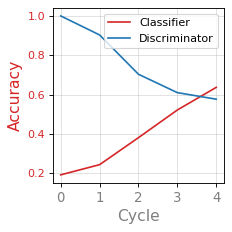

In [18]:
R.plot()

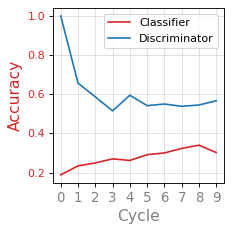

In [18]:
R.plot()

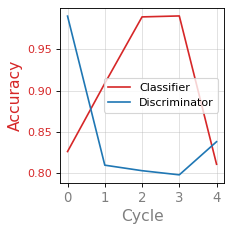

In [17]:
R.plot()